In [1]:
import os
import numpy as np

from remi.system import System
from remi.visualize import plot_states, plot_controls, animate
from remi.kinematics import (calc_capture_point_position,
                             calc_end_effector_position,
                             calc_end_effector_velocity,
                             calc_capture_point_velocity,
                             calc_capture_point_acceleration,
                             calc_J,
                             calc_J_dot)
from remi.clik_functions import get_gam2_vals, calc_clik_params
from remi.dynamics import inverse_dynamics

In [2]:
# Physical Parameters
r_s = np.array([-1.25, 0.])
r_t = np.array([1.25, 0.])
rho = np.array([0.5, 0.5, 0.5, 0.5])
m = np.array([250., 25., 25., 180.])
I = np.array([25., 2.5, 2.5, 18.])
d = np.zeros(4)

# Simulation Settings
t_dur = 5.
step_size = 0.1
tol = 0.01
max_tau = (1000, 1000, 1000, 0.)

# Initial Conditions
y0 = np.array([np.pi/2.,    # theta_s
               -0.3,        # theta_1
               -0.1,        # theta_2
               0.,          # theta_t
               0.,          # theta_dot_s
               0.,          # theta_dot_1
               0.,          # theta_dot_2
               -0.2])       # theta_dot_t


# Put parameters and settings in dict
parameters = dict(r_s=r_s,
                  r_t=r_t,
                  rho=rho,
                  m=m,
                  I=I,
                  d=d)

settings = dict(t_dur=t_dur,
                step_size=step_size,
                tol=tol,
                max_tau=max_tau)

# Define system
sys = System(y0, parameters, settings)

In [3]:
# # System limits
# q_bar = np.zeros(3)
# q_max = np.array([2.*np.pi, # theta_s limit -> NOTE: will make p1 0
#                   np.pi/2., # theta_1 limit
#                   np.pi])   # theta_2 limit
# q_min = -q_max

# p = np.array([0., 1., 1.])
# w = np.ones(6) # w11 w12 w21 w22 w31 w32

# KD = 1.
# KP = 1.
# KN = 1.

# q = y0[:3]
# qdot = y0[4:-1]

# xd = calc_capture_point_position(y0, rho, r_t)
# xe = calc_end_effector_position(y0, rho, r_s)

# e = xd - xe

# vd = calc_capture_point_velocity(y0, rho, r_t)
# ve = calc_end_effector_velocity(y0, rho, r_s)

# e_dot = ve - vd

# ad = calc_capture_point_acceleration(y0, 0., rho, r_t)

# J = calc_J(y0, rho, r_s)
# J_pinv = np.linalg.pinv(J)
# J_dot = calc_J_dot(y0, rho, r_s)
# J_dot_pinv = np.linalg.pinv(J_dot)

# # INFER P AND W HERE
# pos, vel, djk, djk_dot = get_gam2_vals(y0, rho, r_s, r_t)

# # INFER KP, KD, AND KN HERE TOO

# qddot_P = (J_pinv@(ad + KD*e_dot + KP*e - (J_dot@qdot)[:, None])).squeeze()

# lam, lam_dot = calc_clik_params(y0, rho, r_s, pos, vel, p, q_bar, q_max, q_min, w)

# edot_N = (np.eye(3) - J_pinv@J)@(lam.squeeze() - qdot)

# qddot_S = (np.eye(3) - J_pinv@J)@(lam_dot.squeeze() + KN*edot_N) - \
#           (J_pinv@J_dot@J_pinv + J_dot_pinv)@J@(lam.squeeze() - qdot)

# qddot = qddot_P + qddot_S

# tau = inverse_dynamics(y0, np.hstack((qddot, 0.)), r_s, r_t, rho, m, I, d)
# print(tau)

Kp = 5e-1*eye(3); % KP-gain for position error for end-effector \
Kd = 5e0*eye(3); % KD-gain for velocity error for end-effector \
Kn = 1e0*eye(6); % Gain matrix for null space velocity vector error

In [4]:
# CLIK control goes here...
def controls(t, y):
    # System limits
    q_bar = np.zeros(3)
    q_max = np.array([2.*np.pi, # theta_s limit -> NOTE: will make p1 0
                    np.pi/2., # theta_1 limit
                    np.pi])   # theta_2 limit
    q_min = -q_max

    # Specific states
    q = y[:3]
    qdot = y[4:-1]

    # Compute error and derivative error
    xd = calc_capture_point_position(y, rho, r_t)
    xe = calc_end_effector_position(y, rho, r_s)
    vd = calc_capture_point_velocity(y, rho, r_t)
    ve = calc_end_effector_velocity(y, rho, r_s)

    e = xd - xe
    e_dot = ve - vd

    # Capture point acceleration used in qddot_P calc
    ad = calc_capture_point_acceleration(y, 0., rho, r_t)

    # Calc and cache Jacobian information
    J = calc_J(y, rho, r_s)
    J_pinv = np.linalg.pinv(J)
    J_dot = calc_J_dot(y, rho, r_s)
    J_dot_pinv = np.linalg.pinv(J_dot)

    # Calculate parameters for gam2 calculation and for inference input
    pos, vel, djk, djk_dot = get_gam2_vals(y, rho, r_s, r_t)

    # INFER P, W, KP, KD, AND KN HERE
    p = np.array([10., 1e-2, 1e-2])
    w = np.ones(6)*2 # w11 w12 w21 w22 w31 w32
    KD = 5.
    KP = 5e-1
    KN = 1.

    # Calculate parameters for qddot_S
    lam, lam_dot = calc_clik_params(y, rho, r_s, pos, vel, p, q_bar, q_max, q_min, w)
    edot_N = (np.eye(3) - J_pinv@J)@(lam.squeeze() - qdot)

    # Apply gains and previous information to get primary desired
    # acceleration and secondary desired acceleration
    qddot_P = (J_pinv@(ad + KD*e_dot + KP*e - (J_dot@qdot)[:, None])).squeeze()
    qddot_S = (np.eye(3) - J_pinv@J)@(lam_dot.squeeze() + KN*edot_N) - \
            (J_pinv@J_dot@J_pinv + J_dot_pinv)@J@(lam.squeeze() - qdot)

    # Calculate complete desired acceleration
    qddot = qddot_P + qddot_S

    # Compute inverse dynamics to find proper control input
    tau = inverse_dynamics(y, np.hstack((qddot, 0.)), r_s, r_t, rho, m, I, d)
    return tau


def event(t, y, tol):
    ee = calc_end_effector_position(y, rho, r_s)
    capt = calc_capture_point_position(y, rho, r_t)
    dist = np.sqrt((ee[0] - capt[0])**2 + (ee[1] - capt[1])**2)

    return dist <= tol

In [5]:
sys.set_controller(controls)
sys.set_event(event)

In [6]:
sol = sys.run()

<lambdifygenerated-1>:10: RuntimeWarning: overflow encountered in scalar multiply
  return array([[(-d_s - 1.0*m_1*(-2*_Dummy_34*_Dummy_37*rho_1*rho_s*sin(_Dummy_41) - _Dummy_37**2*rho_1*rho_s*sin(_Dummy_41)) - 1.0*m_2*(2*rho_1*rho_2*cos(_Dummy_40) + rho_2**2 + rho_2*rho_s*cos(_Dummy_40 + _Dummy_41))*(-2.0*_Dummy_34**2*m_2*rho_1*rho_2*sin(_Dummy_40) - 1.0*_Dummy_34**2*m_2*rho_2*rho_s*sin(_Dummy_40 + _Dummy_41) - 4.0*_Dummy_34*_Dummy_37*m_2*rho_1*rho_2*sin(_Dummy_40) - 2.0*_Dummy_37**2*m_2*rho_1*rho_2*sin(_Dummy_40) - d_2 + tau_2 - (2.0*m_2*rho_1*rho_2*cos(_Dummy_40) + 1.0*m_2*rho_2**2 - (1.0*m_1*(rho_1**2 + rho_1*rho_s*cos(_Dummy_41)) + 1.0*m_2*(4*rho_1**2 + 4*rho_1*rho_2*cos(_Dummy_40) + 2*rho_1*rho_s*cos(_Dummy_41) + rho_2**2 + rho_2*rho_s*cos(_Dummy_40 + _Dummy_41)))*(2.0*m_2*rho_1*rho_2*cos(_Dummy_40) + 1.0*m_2*rho_2**2 + 1.0*m_2*rho_2*rho_s*cos(_Dummy_40 + _Dummy_41))/(1.0*I_s + 1.0*m_1*(rho_1**2 + 2*rho_1*rho_s*cos(_Dummy_41) + rho_s**2) + 1.0*m_2*(4*rho_1**2 + 4*rho_1*rho_2*cos(

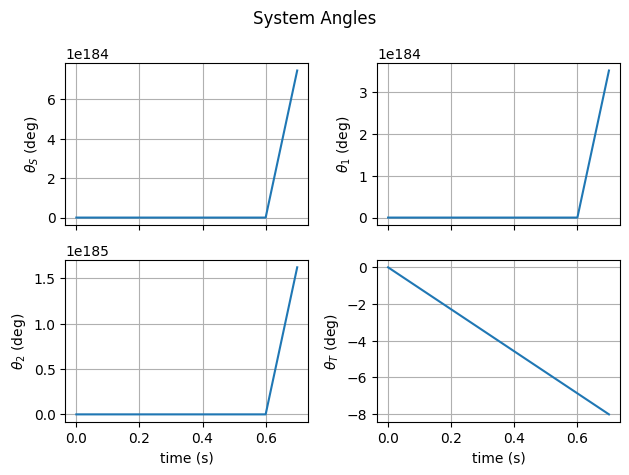

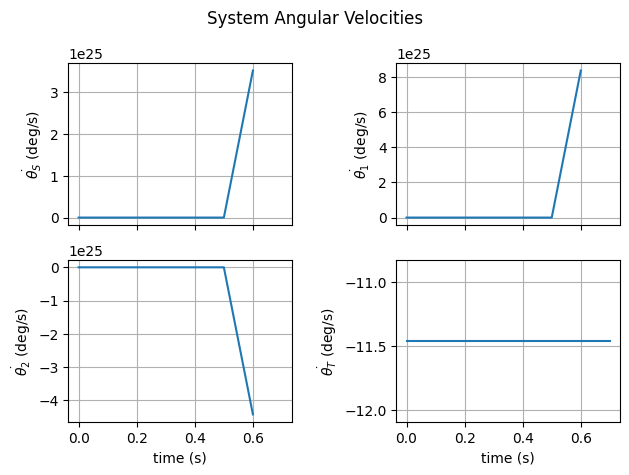

In [7]:
plot_states(sol.t, sol.y, save=False, show=True)

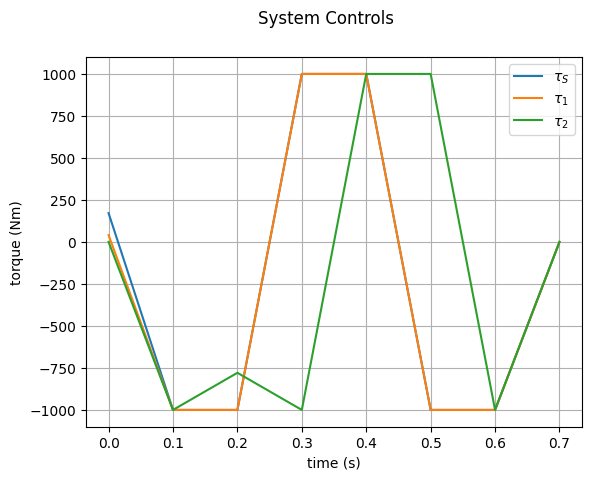

In [ ]:
try:
    plot_controls(sol.t[:-1], sol.u, save=False, show=True)
except:
    plot_controls(sol.t, sol.u, save=False, show=True)

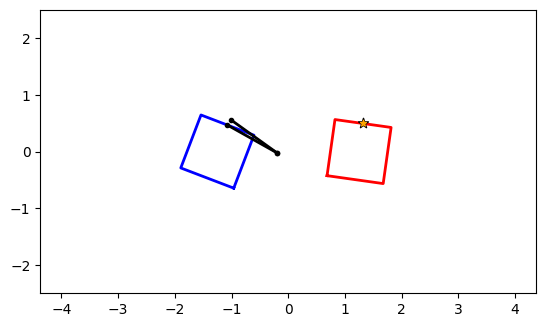

In [9]:
animate(sol.y, parameters, os.getcwd(), blit=True)#, frames=[i for i in range(len(sol.t)) if i%10 == 0])